In [1]:
@everywhere using FunctionalCollections
@everywhere using Iterators
@everywhere using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../util/")


4-element Array{ByteString,1}:
 "/home/ubuntu/build/julia-master/usr/local/share/julia/site/v0.5"
 "/home/ubuntu/build/julia-master/usr/share/julia/site/v0.5"      
 "."                                                              
 "../util/"                                                       

In [2]:
function jaccard_index(aa,bb)
    length(intersect(aa,bb))/length(union(aa,bb))
end

jaccard_index (generic function with 1 method)

In [3]:
using JLD

brown_glove300_raw = load("results/bags/brown_glove300_res.jld", "res")
brown_glove50_raw = load("results/bags/brown_glove50_res.jld", "res")

42004-element Array{Any,1}:
 (ASCIIString["``","only","a","relative","handful","of","such","reports","was","received"  …  "of","voters","and","the","size","of","this","city","''","."],ASCIIString["that","that","that","that","that","that","that","it","that","of"  …  "marginal","marc","thereon","gunning","ledford","market-place","included","on","than","as"],-2.6416790753173873)                               
 (ASCIIString["it","recommended","that","fulton","legislators","act","``","to","have","these"  …  "to","the","end","of","modernizing","and","improving","them","''","."],ASCIIString["we","not","not","government","it","its","law","these","to","in"  …  "revised","jenks","selma","recurrent","reuben","tracked","should","there","symbolically","working"],-3.467678697624857)            
 (ASCIIString["the","grand","jury","commented","on","a","number","of","other","topics"  …  "inure","to","the","best","interest","of","both","governments","''","."],ASCIIString["they","have","have","they","tha

In [4]:
@assert all([rset[1] for rset in brown_glove50_raw] .== [rset[1] for rset in brown_glove300_raw])

In [5]:
using DataFrames

In [6]:
bag_res = DataFrame()
bag_res[:ground] = Set{ASCIIString}[Set{ASCIIString}(rset[1]) for rset in brown_glove50_raw]
bag_res[:ground_len] = Int[length(ss) for ss in bag_res[:ground]]
exp_names = ASCIIString[]
for raw_name in ["brown_glove50_raw", "brown_glove300_raw"]
    colname = split(raw_name,"_")[2] 
    push!(exp_names, colname)
    raw = eval(raw_name|>Symbol)
    bag_res[colname*"_actual"|> Symbol] = Set{ASCIIString}[Set{ASCIIString}(rset[2]) for rset in raw]
    #bag_res[colname*"_distance"|> Symbol] = Float64[-1*rset[3] for rset in raw]
end

bag_res

,ground,ground_len,glove50_actual,glove300_actual
1,"Set(ASCIIString[""widespread"",""jury"",""number"",""``"",""such"",""a"",""was"",""and"",""handful"","","",""reports"",""relative"",""considering"",""this"",""received"",""in"",""."",""''"",""the"",""election"",""voters"",""said"",""size"",""interest"",""of"",""only"",""city""])",27,"Set(ASCIIString[""public"",""percent"",""general"",""national"",""marc"",""people"",""a"",""more"",""that"",""this"",""petty"",""it"",""in"",""market-place"",""included"",""charlotte"","":"",""attu"",""the"",""gunning"",""ledford"",""awards"",""of"",""marginal"",""on"",""as"",""he"",""stark"",""thereon"",""than""])","Set(ASCIIString[""ran"",""number"",""jury"",""widespread"",""``"",""any"",""meanwhile"",""a"","","",""relative"",""this"",""received"",""it"",""23-year-old"",""in"",""include"",""."",""the"",""example"",""election"",""voters"",""said"",""size"",""were"",""interest"",""of"",""city"",""unavailable""])"
2,"Set(ASCIIString[""recommended"",""``"",""that"",""."",""''"",""legislators"",""of"",""revised"",""to"",""studied"",""and"",""these"",""modernizing"",""it"",""have"",""improving"",""act"",""the"",""end"",""them"",""fulton"",""laws""])",22,"Set(ASCIIString[""we"",""not"",""working"",""government"",""recurrent"",""should"",""law"",""new"",""measures"",""revised"",""jenks"",""to"",""symbolically"",""there"",""and"",""selma"",""these"",""it"",""in"",""reuben"",""tracked"",""its""])","Set(ASCIIString[""they"",""recommended"",""``"",""inspired"",""."",""improve"",""''"",""years"",""forcing"",""analysed"",""legislators"",""of"",""law"",""revised"",""to"",""there"",""specifically"",""meanwhile"",""and"",""these"",""modernizing"",""it"",""act"",""the"",""end"",""subdues"",""fulton""])"
3,"Set(ASCIIString[""generally"",""commented"",""number"",""jury"",""county"",""inure"",""``"",""both"",""a"",""among"",""and"","","",""follow"",""it"",""topics"",""well"",""best"",""."",""atlanta"",""''"",""the"",""said"",""interest"",""practices"",""of"",""them"",""governments"",""fulton"",""other"",""are"",""on"",""grand"",""purchasing"",""operated"",""departments"",""accepted"",""to"",""which""])",38,"Set(ASCIIString[""stevens"",""they"",""kong"",""school"",""chromatics"",""walks"",""principal"",""for"",""state"",""feis"",""sweeney"",""clarifies"",""that"",""this"",""music"",""it"",""have"",""in"",""department"",""constance"",""business"",""work"",""secured"",""captive"",""should"",""of"",""law"",""its"",""other"",""main"",""categories""])","Set(ASCIIString[""public"",""organization"",""we"",""flows"",""author"",""will"",""ranging"",""best"",""veterinarians"",""review"",""of"",""urging"",""respectively"",""to"",""and"",""whereby"",""brad"",""breaker"",""received"",""subdued"",""contrarily"",""primarily"",""other"",""on"",""purchasing"",""connection"",""they"",""pfaff"",""``"",""presided"",""stereotype"",""government"",""but"","","",""baker"",""atlanta"",""kolpakova"",""practice"",""are"",""grand"",""which"",""county"",""litta"",""it"",""business"",""the"",""illuminating"",""76"",""meaningfulness"",""divided"",""constable""])"
4,"Set(ASCIIString[""merger"",""proposed""])",2,"Set(ASCIIString[""merger"",""proposed""])","Set(ASCIIString[""merger"",""proposed""])"
5,"Set(ASCIIString[""``"","","",""achieve"",""."",""''"",""greater"",""reduce"",""said"",""believes"",""should"",""be"",""of"",""to"",""jury"",""and"",""these"",""it"",""however"",""the"",""offices"",""administration"",""cost"",""combined"",""two"",""efficiency""])",25,"Set(ASCIIString[""officer"",""anania"",""we"",""sequestration"",""for"",""state"","","",""more"",""that"",""akin"",""g"",""less"",""froze"",""of"",""to"",""ward"",""traverse"",""handful"",""did"",""must"",""economic"",""its"",""efficiency"",""fromm""])","Set(ASCIIString[""``"","","",""achieve"",""."",""''"",""greater"",""reduce"",""said"",""believes"",""be"",""should"",""of"",""to"",""jury"",""and"",""these"",""it"",""however"",""the"",""offices"",""administration"",""cost"",""combined""

In [7]:
for exp_name in exp_names
    actual = bag_res[exp_name*"_actual" |> symbol]
    bag_res[exp_name*"_perfect" |> symbol] = actual.==bag_res[:ground]
    bag_res[exp_name*"_jaccard" |> symbol] = map(jaccard_index, actual, bag_res[:ground])
end

In [9]:
jaccard_cols = Symbol[exp_name*"_jaccard" |> symbol for exp_name in exp_names]
len_scores = aggregate(bag_res[[:ground_len, jaccard_cols...]], :ground_len, mean)
sort!(len_scores)

,ground_len,glove50_jaccard_mean,glove300_jaccard_mean
1,1,1.0,1.0
2,2,0.9142949189985272,1.0
3,3,0.7142229396466685,1.0
4,4,0.524056606492867,1.0
5,5,0.3723900718513837,0.9976348155156104
6,6,0.24879347564843335,0.9946074964639321
7,7,0.19677857390637982,0.9952973190152677
8,8,0.16026497260200404,0.9937614154251936
9,9,0.14076167918976365,0.9921401890151891
10,10,0.13096020450913382,0.9895523449111349


In [42]:
cum_len_scores = DataFrame()
cum_len_scores[:max_ground_len] = bag_res[:ground_len] |> unique |> sort!
for jaccard_col in jaccard_cols
    cum_len_scores[jaccard_col] = Float64[ begin
            shortish_sents = bag_res[:ground_len] .<= max_len;
            bag_res[shortish_sents, jaccard_col] |> mean
         end for max_len in cum_len_scores[:max_ground_len]]
end
cum_len_scores


,max_ground_len,glove50_jaccard,glove300_jaccard
1,1,1.0,1.0
2,2,0.9397580227743272,1.0
3,3,0.8291771094402673,1.0
4,4,0.728984051263121,1.0
5,5,0.6318115885675698,0.9993554832264511
6,6,0.5391850088399045,0.9982072613550296
7,7,0.4685009442994741,0.9976065525739792
8,8,0.4098619216587091,0.9968750510458392
9,9,0.3659150682679186,0.9961017990949026
10,10,0.3336360309053252,0.9952020089270366


In [11]:
using Gadfly

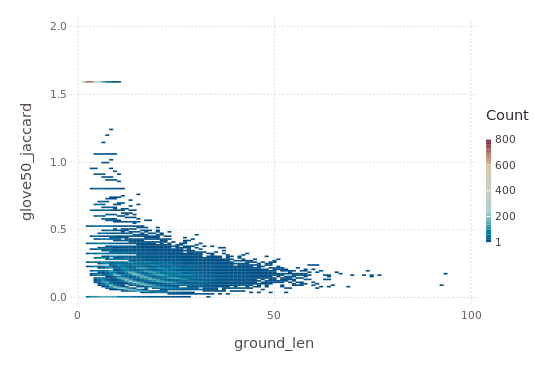

In [18]:
plot(bag_res, x="ground_len", y="glove50_jaccard", Geom.histogram2d)

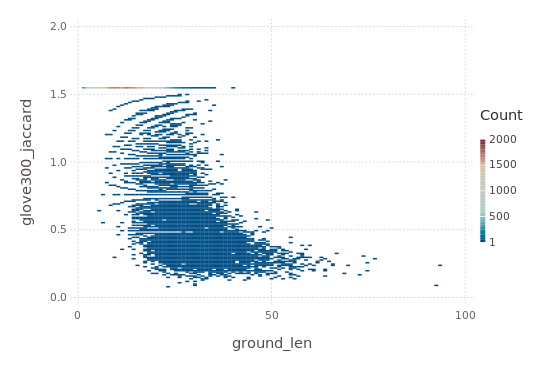

In [16]:
plot(bag_res, x="ground_len", y="glove300_jaccard", Geom.histogram2d)

Summary Stats:


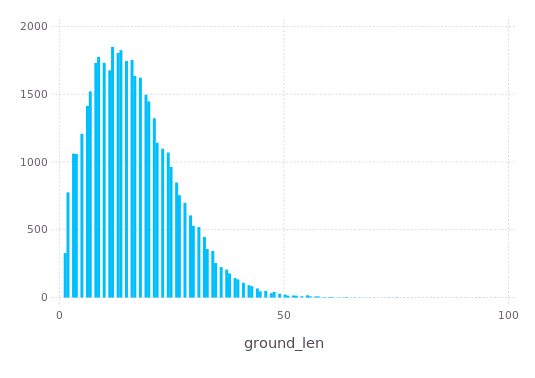

Mean:         16.477264
Minimum:      1.000000
1st Quartile: 9.000000
Median:       15.000000
3rd Quartile: 22.000000
Maximum:      94.000000


In [19]:
bag_res[:ground_len] |> describe 
plot(bag_res, x="ground_len",  Geom.histogram)